# Stacking Models

#### This code takes models created from Train.ipynb and trains a new model by stacking them

In [1]:
"""
Torchvision
"""
# Basics
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# For CNN
import torch.nn as nn
import torch.nn.functional as F
# For Loss Func. And Optimization
import torch.optim as optim
# Utility
import torchvision.datasets
from torchvision.datasets import ImageFolder as img_fold
from torchvision.utils import save_image

"""
Numpy
"""
# For plots and 
import numpy as np

"""
Sklearn
"""
# Validation and Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


"""
Extra
"""
# 
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [2]:
BATCH_SIZE = 32
EPOCHS = 100
WORKERS = 4
RANDOM_STATE = 42

NUM_CLASSES = 10

if torch.cuda.is_available():
    print("Available")
    device = torch.device("cuda")
    print("")
    
# Image Categories
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

# normalizer
transformer = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Available



In [3]:
"""
Bringing in CIFAR10 training and test data
"""
CIFAR_Train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformer)
CIFAR_Test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transformer)

"""
Bringing in custom data
"""
# Setting root directory for custom training and test data
trainroot = "./CNN_Dataset/Level 1"
testroot = "./Noiseimg/test"

trainset = img_fold(root=trainroot, transform=transformer)
noise_testset = img_fold(root=testroot, transform=transformer)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Storing tensors for images and labels in custom dataset
# Not necessary to run if training on the CIFAR10 dataset
img, label = trainset[0][0], trainset[0][1]

# Verifying information
print(f"Image tensor:\n\n{img}\n")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:

tensor([[[0.5059, 0.7725, 0.7255,  ..., 0.4745, 0.8275, 0.6863],
         [0.4902, 0.8275, 0.8980,  ..., 0.3490, 0.6078, 0.5529],
         [0.6863, 0.5451, 0.7725,  ..., 0.4510, 0.6000, 0.6471],
         ...,
         [0.4745, 0.9608, 0.5373,  ..., 0.4275, 0.6235, 0.4824],
         [0.7804, 0.7804, 0.4824,  ..., 0.7725, 0.3882, 0.7412],
         [0.4431, 0.6941, 0.8353,  ..., 0.5294, 0.7961, 0.5608]],

        [[0.8667, 0.9216, 0.9137,  ..., 0.7961, 0.6784, 0.3490],
         [0.5216, 0.7020, 0.6549,  ..., 0.5451, 0.7647, 0.6314],
         [0.6078, 0.7490, 0.4980,  ..., 0.9843, 0.6863, 1.0000],
         ...,
         [0.4824, 0.5451, 1.0000,  ..., 0.3333, 0.8196, 0.6157],
         [0.8118, 0.5843, 0.8588,  ..., 0.7804, 0.5608, 0.4902],
         [0.5843, 0.7882, 0.4118,  ..., 0.3647, 0.6941, 0.6000]],

        [[0.6549, 0.6863, 0.7490,  ..., 0.6863, 0.7098, 0.5922],
         [0.8039, 1.0000, 0.7098,  ..., 0.3961, 0.6078, 0.6784],
         [0.4431, 0.8353, 0.9451,  ..., 0.8

In [5]:
# Grabbing labels from dataset
# Modify depending on what dataset you use
class_names = CIFAR_Train.classes
print('Labels: ',class_names,'\n')

# Verifying length of CIFAR10 Dataset
print('CIFAR10 Trainset Length: ', len(CIFAR_Train))
print('CIFAR10 Testset Length: ', len(CIFAR_Test),'\n')

# Verifying length of custom dataset
print('Custom Trainset Length: ', len(trainset))
print('Custom Testset Length: ', len(noise_testset))

Labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

CIFAR10 Trainset Length:  50000
CIFAR10 Testset Length:  10000 

Custom Trainset Length:  5000
Custom Testset Length:  1000


In [6]:
"""
Creating dataloaders
"""

# Modify depending on what dataset you want to use
trainloader = torch.utils.data.DataLoader(CIFAR_Train, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=4)

# TestLoader for CIFAR10 images
CIFAR10_testloader=torch.utils.data.DataLoader(CIFAR_Test, batch_size = BATCH_SIZE,
                                            shuffle=True, num_workers=4)


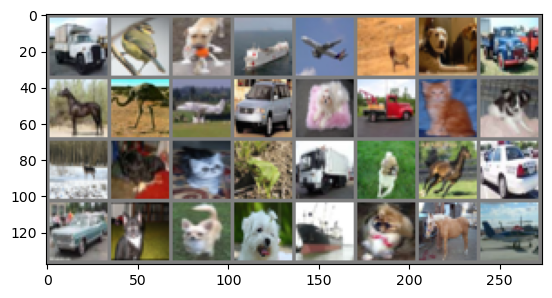

Actual labels:  truck bird dog ship airplane deer dog truck horse bird airplane automobile dog truck cat dog deer dog cat frog truck dog horse automobile automobile cat dog dog ship dog horse airplane


In [7]:
"""
Showing sample images from training set
"""
# Defining function to show images from training set
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Randomly select images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels for each shown image
print('Actual labels: ', ' '.join(f'{class_names[labels[j]]}' for j in range(BATCH_SIZE)))

In [8]:
# Verifying information
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([3, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [42]:
def kfold_train_model_stacking(model1, model2, stacking_model, dataset, criterion, optimizer, device, k_folds, epochs, batch_size, workers, patience):
    
    writer = SummaryWriter()
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        
        # Data splitting
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        val_dataset = torch.utils.data.Subset(dataset, val_idx)

        # Creating dataloaders
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
        valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

        model1.to(device)
        model2.to(device)
        stacking_model.to(device)

        # Move optimizer to GPU. Necessary for optimizers like Adagrad
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)

        # Training loop for each epoch
        for epoch in range(epochs):
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Training phase
            model1.train()
            model2.train()
            stacking_model.train()

            best_val_loss = float('inf')
            no_improvement_epochs = 0

            for i, (images, labels) in enumerate(trainloader):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward pass through individual models
                outputs_model1 = model1(images)
                outputs_model2 = model2(images)
                
                """
                # Print the shapes of the outputs
                print("Output shape from model1:", outputs_model1.shape)
                print("Output shape from model2:", outputs_model2.shape)
                """
                
                # Concatenate outputs of individual models
                concatenated_outputs = torch.cat((outputs_model1, outputs_model2), dim=1)
                
                """
                print("Concatenated output shape:", concatenated_outputs.shape)
                """
                
                
                # Forward pass through stacking model
                final_outputs = stacking_model(concatenated_outputs)

                loss = criterion(final_outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(final_outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Print intermediate values
                if i % 100 == 99:  # Print every 100 batches
                    train_accuracy_batch = correct_train / total_train
                    print(f'Fold {fold + 1}, Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}, Accuracy: {100 * train_accuracy_batch:.2f}')

            train_accuracy = correct_train / total_train

            # Validation phase
            model1.eval()
            model2.eval()
            stacking_model.eval()

            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for images, labels in valloader:
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass through individual models
                    outputs_model1 = model1(images)
                    outputs_model2 = model2(images)

                    # Concatenate outputs of individual models
                    concatenated_outputs = torch.cat((outputs_model1, outputs_model2), dim=1)

                    # Forward pass through stacking model
                    final_outputs = stacking_model(concatenated_outputs)

                    loss = criterion(final_outputs, labels)
                    val_loss += loss.item()

                    # calculate accuracy for validation
                    _, predicted = torch.max(final_outputs.data, 1)
                    val_total_samples += labels.size(0)
                    val_correct_predictions += (predicted == labels).sum().item()

            val_accuracy = val_correct_predictions / val_total_samples

            # Print loss and accuracy per epoch for both training and validation
            print(f'Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader):.3f}, Training Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {val_loss / len(valloader)}, Validation Accuracy: {val_accuracy:.2%}')

            # TensorBoard logging
            writer.add_scalar(f'Loss/Train/Fold_{fold + 1}', running_loss / len(trainloader), epoch)
            writer.add_scalar(f'Loss/Validation/Fold_{fold + 1}', val_loss / len(valloader), epoch)
            writer.add_scalar(f'Accuracy/Train/Fold_{fold + 1}', 100 * train_accuracy, epoch)
            writer.add_scalar(f'Accuracy/Validation/Fold_{fold + 1}', 100 * val_accuracy, epoch)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= patience:
                print(f'Early stopping! No improvement in validation loss for {patience} epochs.')
                break

            print("")

    # Close TensorBoard writer
    writer.close()
    print("Training Complete")

In [10]:
# Test Function
def test_model(model, model_name, testloader, device):
    
    """
    Test the model on the entire dataset and store statistics.

    Args:
        model (nn.Module): The neural network model.
        model_name: Name of the neural network model. Used in storing statistics
        testloader (DataLoader): DataLoader for the test dataset.
        device: The device to which the model and data should be moved (e.g., "cuda" or "cpu").

    """
    model.to(device)
    model.eval()
    
    correct = 0 
    total = 0
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Pick class with highest similarity score
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the test images: {100 * correct // total} %\n')
    

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        
    # store statistics
    write_accuracy_to_file(f'{model_name}_accuracy.txt', model_name, correct, total, correct_pred, total_pred, EPOCHS)

# Saving statistics    
def write_accuracy_to_file(filename, model_name, correct, total, correct_pred, total_pred, epochs):

    """
    Store model statistics. Designed to be called within test_model function
    """
    # Open the specified text file in write mode
    with open(filename, 'w') as file:
        # Write overall accuracy to the file
        file.write(f'Model: {model_name}\n\n')
        file.write(f'Total Epochs: {epochs}\n\n')
        file.write(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n\n')

        # Write accuracy for each class to the file
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            file.write(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %\n')

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Creating three convolutional layers and utilizing batch normalization after each convolution
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        
        # Dropout Layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

        # Pooling and fully connected layers
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.batch_norm_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.batch_norm_fc3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.batch_norm_fc4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        
        x = F.relu(self.batch_norm_fc1(self.fc1(x)))
        x = F.relu(self.batch_norm_fc2(self.fc2(x)))
        x = F.relu(self.batch_norm_fc3(self.fc3(x)))
        x = F.relu(self.batch_norm_fc4(self.fc4(x)))
        
        x = self.fc5(x)

        return x

In [44]:
class StackingNet(nn.Module):
    def __init__(self):
        super(StackingNet, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(20, 1024)  # Adjust input size to match the concatenated output size
        self.batch_norm_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.batch_norm_fc3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.batch_norm_fc4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 10)

        # Dropout Layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.batch_norm_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.batch_norm_fc3(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.batch_norm_fc4(self.fc4(x)))
        x = self.fc5(x)

        return x

In [45]:
# Creating new models

train = StackingNet()
m1 = Net()
m2 = Net()

# Copying weights of old models to stack
m1.load_state_dict(torch.load('./Models/Merged_Kfold_AdaGrad_F10_E100_B32_W4.pth'))
m2.load_state_dict(torch.load('./Models/Merged_Kfold_Adam_F10_E50_B32_W4.pth'))

<All keys matched successfully>

In [46]:
# Setting up loss func. and optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(test.parameters(), lr = 0.00001, momentum = 0.9, weight_decay=.001)
# optimizer = optim.Adam(test.parameters(), lr = 0.0001, weight_decay=.001)
optimizer = optim.Adam(train.parameters(), lr=0.001, weight_decay=0.001)

In [47]:
kfold_train_model_stacking(m1, m2, train, CIFAR_Train, criterion, optimizer, device, 10, EPOCHS, BATCH_SIZE, 4, 2)

Fold 1, Epoch 1, Batch 100, Loss: 0.4895648956298828, Accuracy: 86.97
Fold 1, Epoch 1, Batch 200, Loss: 0.11273559182882309, Accuracy: 90.28
Fold 1, Epoch 1, Batch 300, Loss: 0.26006293296813965, Accuracy: 91.56
Fold 1, Epoch 1, Batch 400, Loss: 0.23534120619297028, Accuracy: 92.02
Fold 1, Epoch 1, Batch 500, Loss: 0.28352758288383484, Accuracy: 92.49
Fold 1, Epoch 1, Batch 600, Loss: 0.3171573579311371, Accuracy: 92.79
Fold 1, Epoch 1, Batch 700, Loss: 0.027437549084424973, Accuracy: 92.88
Fold 1, Epoch 1, Batch 800, Loss: 0.07546218484640121, Accuracy: 93.02
Fold 1, Epoch 1, Batch 900, Loss: 0.09163587540388107, Accuracy: 93.16
Fold 1, Epoch 1, Batch 1000, Loss: 0.03326268494129181, Accuracy: 93.34
Fold 1, Epoch 1, Batch 1100, Loss: 0.19545093178749084, Accuracy: 93.38
Fold 1, Epoch 1, Batch 1200, Loss: 0.11807885766029358, Accuracy: 93.49
Fold 1, Epoch 1, Batch 1300, Loss: 0.053736332803964615, Accuracy: 93.58
Fold 1, Epoch 1, Batch 1400, Loss: 0.06417648494243622, Accuracy: 93.68
F